# Resume Parsing

## 1. Load data

In [69]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [70]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [71]:
df_resume.shape

(2484, 4)

In [72]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [73]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [74]:
ruler = nlp.add_pipe("entity_ruler", before='ner')
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler',
 'ner']

In [75]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

### Add More patterns

In [76]:
ph_no_patterns = [
    {"label": "PHONE_NUMBER", "pattern": [{"ORTH": "("},  {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "ddd"},
                                            {"ORTH": "-", "OP": "?"}, {"SHAPE": "dddd"}]}
]
ruler.add_patterns(ph_no_patterns)

In [77]:
doc = nlp("My name is Wut Yee Aung. My friends call me Putoo")

for ent in doc.ents:
    print(ent.text, ent.label_)

Wut Yee Aung PERSON


In [78]:
email_pattern = [
    {"label": "EMAIL", "pattern": [{"TEXT": {"REGEX": r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"}}]}
]
ruler.add_patterns(email_pattern)

In [85]:
doc = nlp("My email is st124377@ait.asia.")

for ent in doc.ents:
    print(ent.text, ent.label_)

st124377@ait.asia EMAIL


In [80]:
edu_patterns = [
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["bsc", "bachelor", "bachelor's", "b.a", "b.s", "b.c.sc"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["msc", "master", "master's", "m.a", "m.s"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["phd", "ph.d", "doctor", "doctorate"]}}, {"IS_ALPHA": True, "OP": "*"}]}
]
ruler.add_patterns(edu_patterns)

In [ ]:
doc = nlp("My degree is Bachelor of Computer Science. Normally we say B.C.Sc")

for ent in doc.ents:
    print(ent.text, ent.label_)

## 3. Let's try to extract skills from this resume.csv

In [56]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
21,18827609,HR ASSOCIATE Professional S...,"<div class=""MPR skn-cbg1 fontsize fontface vma...",HR
1684,83566455,SOURCING & MERCHANDISING ANALYST ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
206,21283733,WEB DESIGNER/GRAPHIC DESIGNER S...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
178,18460045,FREELANCE GRAPHIC DESIGNER ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
559,13080868,BUSINESS DEVELOPMENT Profession...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT


In [82]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [83]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         SALON DESIGNER           Career Overview      Committed and motivated  with exceptional customer service and decision making skills.   Strong work ethic, professional demeanor and great initiative.  Energetic and reliable Office Manager skilled with working with a diverse group of people.  '

In [84]:
preprocessing(random_resume[:300])

'salon designer career overview committed motivate exceptional customer service decision make skill strong work ethic professional demeanor great initiative energetic reliable office manager skilled work diverse group people'

In [60]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [19]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1941,35971546,CONSTRUCTION INSPECTOR Prof...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction inspector professional summary re...
2336,18586076,DANCE EDUCATOR Professional S...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,dance educator professional summary personable...
308,40018190,IT SUPPORT TECHNICIAN Education...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,it support technician education bachelor scien...
1737,55595908,SITE ENGINEERING Career Ove...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,site engineering career overview 10 year total...
84,47470864,GENERAL HR ASSISTANT/OFFICE ASSISTANT...,"<div class=""fontsize fontface vmargins hmargin...",HR,general hr assistant office assistant summary ...


## 4. Let's really extract skills!!

In [20]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [21]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [22]:
df_resume.Skills.iloc[0]

['steel',
 'vendors',
 'procurement',
 'investigation',
 'negotiation',
 'reconcile',
 'd',
 'workforce management',
 'design',
 'contract management',
 'administration',
 'base',
 'warranty',
 'solver',
 'survey',
 'office',
 'accident',
 'management',
 'concrete',
 'persuasion',
 'content',
 'matrix',
 'resolve',
 'drawing',
 'bim',
 'completion',
 'rfi',
 'safety',
 'schedule',
 'documentation',
 'o',
 'maintenance',
 'strategy',
 'quality control',
 'quality assurance',
 'pay',
 'travel',
 'project planning',
 'cross functional',
 'foundation',
 'adt',
 'drive',
 'field production',
 'plan',
 'scheduling',
 'load',
 'process',
 'air',
 'variance analysis',
 'epoxy',
 'customer satisfaction',
 'rebar',
 'soil',
 'coordinated',
 'project',
 'demand',
 'construction',
 'analysis',
 'transport',
 'construction engineering',
 'collaboration',
 'progress billing',
 'record',
 'interpersonal communication',
 'autocad',
 'investment',
 'density',
 'scenario',
 'report writing',
 'insurance

## 5. Visualization

Which skills is most important in information management?

In [23]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [24]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(59, 6)

In [25]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [26]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [27]:
counting

OrderedDict([('information technology', 56),
             ('software', 53),
             ('system', 52),
             ('it', 48),
             ('management', 46),
             ('technical', 45),
             ('project', 41),
             ('technology', 41),
             ('application', 41),
             ('process', 40)])

<BarContainer object of 10 artists>

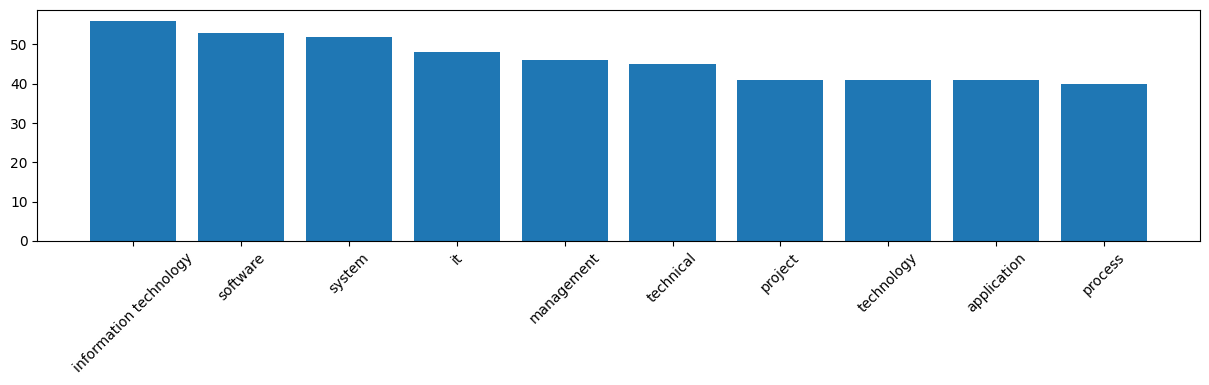

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [29]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [30]:
doc = nlp(text)

In [86]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

colors = {
    "SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "EDUCATION": "linear-gradient(90deg, #ADD8E6, #fc9ce7)",
    "PHONE_NUMBER": "linear-gradient(90deg, #87CEEB, #FFA07A)",
    "EMAIL": "linear-gradient(90deg, #98FB98, #FFD700)"
}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [87]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [88]:
text = preprocessing(text)

In [89]:
doc = nlp(text)

In [90]:
displacy.render(doc, style='ent', options=options)